# 12. PPO 算法

## 12.1 简介
第 11 章中介绍的 TRPO 算法在很多场景上的应用都很成功，但是我们也发现它的计算过程非常复杂，每一步更新的运算量非常大。于是， TRPO 算法的改进版—— PPO 算法在 2017 年被提出， PPO 基于 TRPO 的思想，但是其算法实现更加简单。并且大量的实验结果表明，与 TRPO 相比，PPO 能学习得一样好（甚至更快），这使得 PPO 成为非常流行的强化学习算法，如果我们想要尝试在一个新的环境中使用强化学习算法，那么 PPO 就属于可以首先尝试的算法。

回忆一下 TRPO 的优化目标：

$$
\max_{\theta}\mathbb{E}_{s\sim\nu^{\pi_{\theta_{k}}}}\mathbb{E}_{a\sim\pi_{\theta_{k}}(\cdot|s)}\left[\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)}A^{\pi_{\theta_{k}}} (s,a)\right]
$$

$$
\mathrm{s.t.}\quad\mathbb{E}_{s\sim\nu^{\pi_{\theta_{k}}}}[D_{KL}(\pi_{\theta_{k}}(\cdot|s),\pi_{\theta}(\cdot|s))]\leq\delta
$$

TRPO 使用泰勒展开近似、共轭梯度、线性搜索等方法直接求解。PPO 的优化目标与 TRPO 相同，但 PPO 用了一些相对简单的方法来求解。具体来说，PPO 有两种形式，一是 PPO-惩罚，二是 PPO-截断，我们接下来对这两种形式进行介绍

## 12.2 PPO-惩罚
PPO-惩罚（PPO-Penalty）用拉格朗日乘数法直接将 KL 散度的限制放进了目标函数中，这就变成了一个无约束的优化问题，在迭代的过程中不断更行 KL 散度前的系数，即

$$
\arg\max_{\theta}\mathbb{E}_{s\sim\nu^{\pi_{\theta_{k}}}}\mathbb{E}_{a\sim\pi_{\theta_{k}}(\cdot|s)}\left[\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)}A^{\pi_{\theta_{k}}}(s,a)-\beta D_{KL}[\pi_{\theta_{k}}(\cdot|s),\pi_{\theta}(\cdot|s)]\right]
$$

令 $d_k=D_{KL}^{\nu^{\pi_{\theta_k}}}(\pi_{\theta_k},\pi_\theta)$，$\beta$ 的更新规则如下：
1. 如果 $d_k < \delta/1.5$，那么 $\beta_{k+1} = \beta_k / 2$
2. 如果 $d_k > \delta \times 1.5$，那么 $\beta_{k+1} = \beta_k \times 2$
3. 否则 $\beta_{k+1} = \beta_k$

其中，$\delta$ 是事先设定的一个超参数，用于限制学习策略和之前一轮策略的差距

## 12.3 PPO-截断
PPO 的另一种形式 PPO-截断（PPO-Clip）更加直接，它在目标函数中进行限制，以保证新的参数和旧的参数的差距不会太大，即

$$
\arg\max_{\theta}\mathbb{E}_{s\sim\nu^{\pi_{\theta_k}}}\mathbb{E}_{a\sim\pi_{\theta_{k}}(\cdot|s)}\left[\min\left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)}A^{\pi_{\theta_{k}}}(s,a),\mathrm{clip}\left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)},1-\epsilon,1+\epsilon\right)A^{\pi_{\theta_{k}}}(s,a)\right)\right]
$$

其中 $\text{clip}(x,l,r):=\max(\min(x,r),l)$，即把 $x$ 限制在 $[l,r]$ 内，上式中 $\epsilon$ 是一个超参数，表示进行截断（clip）的范围
如果 $A^{\pi_{\theta_k}}(s,a) > 0$，说明这个动作的价值高于平均，最大化这个式子会增大 $\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)}$，但不会让其超过 $1 + \epsilon$。反之，如果 $A^{\pi_{\theta_k}}(s,a) < 0$，最大化这个式子会减小 $\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{k}}(a|s)}$，但不会让其超过 $1 - \epsilon$。如图 12-1 所示。

<div align="center">
    <img src="./image/12-1.png">
    <center>图12-1 PPO-截断示意图</center>
</div> 

## 12.4 PPO 代码实践
与 TRPO 相同，我们仍然在车杆和倒立摆两个环境中测试 PPO 算法。大量实验表明，PPO-截断总是比 PPO-惩罚表现得更好。因此下面我们专注于 PPO-截断的代码实现。
首先导入一些必要的库，并定义策略网络和价值网络。

In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO 算法，采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO 中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype = torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(
            transition_dict['states'], 
            dtype = torch.float
        ).to(self.device)

        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)

        rewards = torch.tensor(
            transition_dict['rewards'], 
            dtype = torch.float
        ).view(-1,1).to(self.device)

        next_states = torch.tensor(
            transition_dict['next_states'], 
            dtype = torch.float
        ).to(self.device)

        dones = torch.tensor(
            transition_dict['dones'], 
            dtype = torch.float
        ).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)

        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(
            self.gamma, 
            self.lmbda, 
            td_delta.cpu()
        ).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO 损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

接下来在车杆环境中训练 PPO 算法

In [2]:
# import torch
# print(torch.__version__)  # 查看PyTorch版本
# print(torch.cuda.is_available())  # 检查CUDA是否可用
# print(torch.version.cuda)  # 查看CUDA版本

actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecate

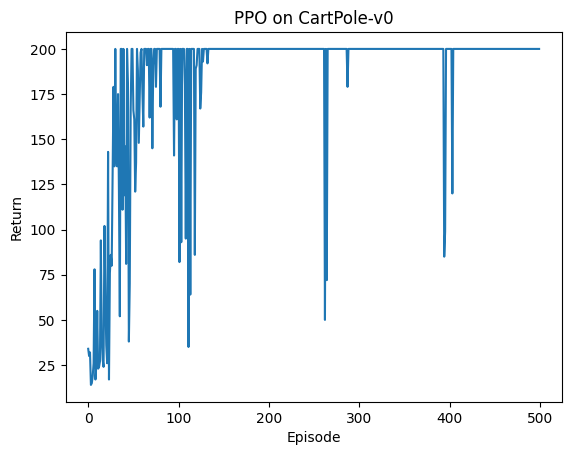

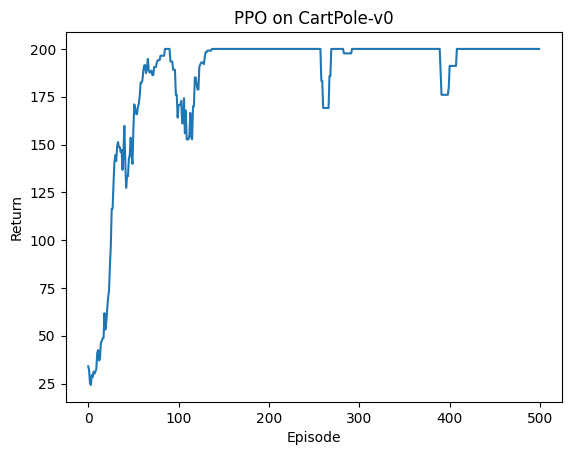

In [3]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('PPO on {}'.format(env_name))
plt.show()

倒立摆是与连续动作交互的环境，同 TRPO 算法一样，我们做一些修改，让策略网络输出连续动作高斯分布（Gaussian distribution）的均值和标准差。后续的连续动作则在该高斯分布中采样得到。

In [4]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std


class PPOContinuous:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype = torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(
            transition_dict['states'], 
            dtype = torch.float
        ).to(self.device)
        actions = torch.tensor(
            transition_dict['actions'], 
            dtype = torch.float
        ).view(-1, 1).to(self.device)
        rewards = torch.tensor(
            transition_dict['rewards'],
            dtype = torch.float
        ).view(-1, 1).to(self.device)
        next_states = torch.tensor(
            transition_dict['next_states'], 
            dtype = torch.float
        ).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype = torch.float).view(-1, 1).to(self.device)
        
        rewards = (rewards + 8.0) / 8.0  # 和 TRPO 一样，对奖励进行修改，方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(
            self.gamma, 
            self.lmbda, 
            td_delta.cpu()
        ).to(self.device)
        
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())

        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(
                    self.critic(states), 
                    td_target.detach()
                )
            )
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

创建环境`Pendulum-v0`，并设定随机数种子以便重复实现。接下来我们在倒立摆环境中训练 PPO 算法。

In [5]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000

hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 0:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 200/200 [00:43<00:00,  4.62it/s, episode=2000, return=-415.200]


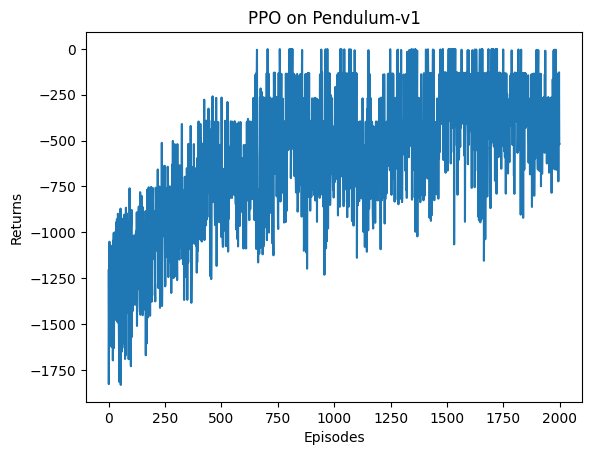

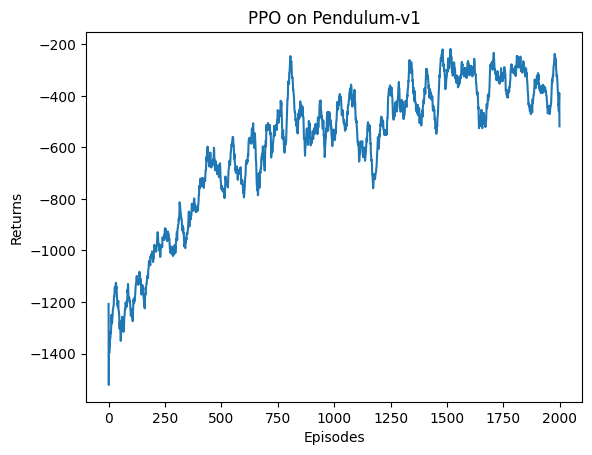

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

## 12.5 总结
PPO 是 TRPO 的一种改进算法，它实现上简化了 TRPO 中的复杂计算，并且它在实验中的性能大多数情况下会比 TRPO 更好，因此目前常被用作一种常用的基准算法。需要注意的是，TRPO 和 PPO 都属于在线策略学习算法，即使优化目标中包含重要性采样的过程，但其只是用到了上一轮策略的数据，而不是过去所有策略的数据。

PPO 是 TRPO 的第一作者 John Schulman 从加州大学伯克利分校博士毕业后在 OpenAI 公司研究出来的。通过对 TRPO 计算方式的改进，PPO 成为了最受关注的深度强化学习算法之一，并其论文的引用量也超越了 TRPO。

## 12.6 参考文献
[1] SCHULMAN J, FILIP W, DHARIWAL P, et al. Proximal policy optimization algorithms [J]. Machine Learning, 2017.